# DIVE INTO CODE COURSE
## Introductory Machine Learning Class assignment Learning Credit Information
### Doan Anh Tien - 1852789 - tien.doan.g0pr0@hcmut.edu.vn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno

## \[Problem 1] Cross Validation

### 1. Load dataset

In [74]:
df = pd.read_csv('drive/MyDrive/Dataset/application_train.csv')

# Check the number of columns and rows of this dataset
print("application_train dataset -- rows: {}, columns: {}".format(df.shape[0], df.shape[1]))

application_train dataset -- rows: 307511, columns: 122


In [75]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Check mising values

In [76]:
# Check missing values
def check_missing(df):
    # Create a hash dictionary contain missing ratio of each feature
    miss_dict = {}
    for columns in df:
        count = df[columns].isna().sum()
        ratio = count/len(df[columns])
        datatype = df[columns].dtype
        miss_dict[columns] = [count, ratio, datatype]
    
    return miss_dict

In [77]:
miss_ratio = pd.DataFrame(check_missing(df), ['Total', 'Ratio', 'Type']).T
print("Missing ratio table")
miss_ratio

Missing ratio table


,Total,Ratio,Type
SK_ID_CURR,0,0,int64
TARGET,0,0,int64
NAME_CONTRACT_TYPE,0,0,object
CODE_GENDER,0,0,object
FLAG_OWN_CAR,0,0,object
...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_WEEK,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_MON,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_QRT,41519,0.135016,float64


### 3. Displaying feature having missing ratio > 0

In [78]:
miss_feature = miss_ratio[miss_ratio.Ratio > 0]
print("Total feature missing values: {}".format(len(miss_feature)))
miss_feature

Total feature missing values: 67


,Total,Ratio,Type
AMT_ANNUITY,12,3.9023e-05,float64
AMT_GOODS_PRICE,278,0.000904033,float64
NAME_TYPE_SUITE,1292,0.00420148,object
OWN_CAR_AGE,202929,0.659908,float64
OCCUPATION_TYPE,96391,0.313455,object
...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_WEEK,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_MON,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_QRT,41519,0.135016,float64


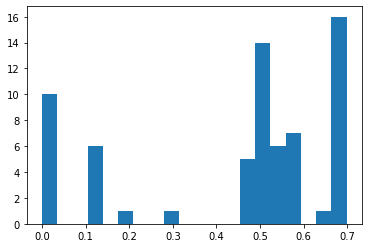

In [79]:
plt.hist(miss_feature['Ratio'], bins=20)
plt.show()

### 4. Testing out the imputer to fill the missing values

In [80]:
# Take the AMT_ANNUITY as an example
print("Number of missing value: {}".format(df['AMT_ANNUITY'].isna().sum()))

Number of missing value: 12


In [81]:
from sklearn.impute import SimpleImputer
import numpy as np
imr = SimpleImputer(missing_values=np.NaN, strategy='mean')
imr = imr.fit(df[['AMT_ANNUITY']])
df['AMT_ANNUITY'] = imr.transform(df[['AMT_ANNUITY']]).ravel()

In [82]:
print("Number of missing value: {}".format(df['AMT_ANNUITY'].isna().sum()))

Number of missing value: 0


## Joining train and test dataset for assesing

## 1. Join the dataset

In [83]:
df_train = pd.read_csv('drive/MyDrive/Dataset/application_train.csv')
df_test = pd.read_csv('drive/MyDrive/Dataset/application_test.csv')

In [84]:
print("The shape of our full dataset: ({}, {})".format(df_train.shape, df_test.shape))

The shape of our full dataset: ((307511, 122), (48744, 121))


In [85]:
target = df_train['TARGET'] 
df_train = df_train.drop('TARGET', axis=1)

In [86]:
df_train['training_dataset'] = True # distinguish the train and test dataset when join them together
df_test['training_dataset'] = False
test_index = df_test['SK_ID_CURR']

In [87]:
df_total = pd.concat([df_train, df_test]) #concatenate both dataframes
df_total = df_total.drop('SK_ID_CURR', axis=1) #drop SK_ID_CURR variable
print("The shape of our full dataset: {}".format(df_total.shape))

The shape of our full dataset: (356255, 121)


### 2. Convert the categorical features into numerical (encoding)

In [88]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
label_en = LabelEncoder()

In [89]:
df_total.dtypes.value_counts()

float64    65
int64      39
object     16
bool        1
dtype: int64

The LabelEncoder function allow us to encode the categorical feature between 0 or 1, so we only get the column with at most 2 labels.

In [90]:
label_en_count = 0 # count the number of categorical features that can be converted
for columns in df_total.columns[1:]: # We do not need the NAME_CONTRACT_TYPE columns since it the same with TARGET variables
    if df_total[columns].dtype == 'object':
        if len(list(df_total[columns].unique())) <= 2:
            label_en.fit(df_total[columns])
            df_total[columns] = label_en.transform(df_total[columns])
            label_en_count += 1
            print("{} have been modified".format(columns))

print('{} columns have been encoded.'.format(label_en_count))

FLAG_OWN_CAR have been modified
FLAG_OWN_REALTY have been modified
2 columns have been encoded.


And those columns with more than 3 features (the columns that were not encoded) will be called dummy data

In [91]:
df_total = pd.get_dummies(df_total)

In [92]:
print("The shape of full ENCODED dataset: {}".format(df_total.shape))

The shape of full ENCODED dataset: (356255, 243)


In [93]:
df_total.dtypes.value_counts()

uint8      136
float64     65
int64       41
bool         1
dtype: int64

In [94]:
df_total.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
1,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


As a result, the number of features have increased from 121 to 243 and all features will have the same format so we can apply such algorithms like Linear Regression or Random Forest Classifier properly.

### 3. Fill all missing values of dataset

In [95]:
print("Total missing value BEFORE imputing: {}".format(df_total.isna().sum().sum()))

Total missing value BEFORE imputing: 9673479


In [96]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def fill_missing_value(df):
    new_df = df
    imr = SimpleImputer(missing_values=np.NaN, strategy='median')
    #scaler = StandardScaler()
    #scaler = MinMaxScaler(feature_range = (0, 1))
    for columns in new_df.columns[2:]:
        #if is_numeric_dtype(new_df[columns]):
        imr_all = imr.fit(new_df[[columns]])
        new_df[columns] = imr_all.transform(new_df[[columns]]).ravel()
        #scaler_all = scaler.fit(new_df[[columns]])
        #new_df[columns] = scaler_all.transform(new_df[[columns]]).ravel()

    return new_df

In [97]:
df_total = fill_missing_value(df_total)

In [98]:
print("Total missing value AFTER imputing: {}".format(df_total.isna().sum().sum()))

Total missing value AFTER imputing: 0


In [99]:
miss_ratio_full = pd.DataFrame(check_missing(df_total), ['Total', 'Ratio', 'Type']).T
print("Missing ratio table after imputing and encoding")
miss_ratio_full

Missing ratio table after imputing and encoding


,Total,Ratio,Type
FLAG_OWN_CAR,0,0,int64
FLAG_OWN_REALTY,0,0,int64
CNT_CHILDREN,0,0,float64
AMT_INCOME_TOTAL,0,0,float64
AMT_CREDIT,0,0,float64
...,...,...,...
WALLSMATERIAL_MODE_Panel,0,0,float64
"WALLSMATERIAL_MODE_Stone, brick",0,0,float64
WALLSMATERIAL_MODE_Wooden,0,0,float64
EMERGENCYSTATE_MODE_No,0,0,float64


In [100]:
print("Total missing value: {}".format(int(miss_ratio_full[miss_ratio_full.Total > 0].sum().sum())))

Total missing value: 0


After using imputer, the number of missing values has dramatically decreased by more than 10 times compared to its raw state. The stategy for imputer is using the median value - calculated from the exist data - to fill up the blanks. And the scaler is used to normalize the range of the features to scale them between values 0 and 1.

At this point, our preprocessing step is more easily to adapt and optimize to the training and learning stage.

In [101]:
df_train = df_total[df_total['training_dataset']==True]
df_train = df_train.drop('training_dataset', axis=1)
df_test = df_total[df_total['training_dataset']==False]
df_test = df_test.drop('training_dataset', axis=1)

In [102]:
print('Size of Train Dataset:', df_train.shape)
print('Size of Test Dataset:', df_test.shape)
print('Size of target:', target.shape)

Size of Train Dataset: (307511, 242)
Size of Test Dataset: (48744, 242)
Size of target: (307511,)


### 4. K-Fold Cross-Validator

In [103]:
from sklearn.model_selection import KFold
# Prepare cross validation
kfolds = KFold(n_splits=5, shuffle=True, random_state=1)

## \[Problem 2] + [Problem 3] + [Problem 4]

### 1. GridSearch CV

From the previous assignment, the Linear Discriminant Analysis turned out to be the best method to predict the probability for this problem. So we will reuse it again, but now with a better condition when combining with GridSearchCV and later with KFold Cross-Validator

First, let standardize our model in order to use the LDA algorithm effectively.

In [118]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = Pipeline([('scaler', StandardScaler()),
                      ('LDA_estimator', LinearDiscriminantAnalysis())])

In [121]:
from sklearn.model_selection import GridSearchCV

## Search grid for optimal parameters
lda_grid = [{"LDA_estimator__solver" : ["svd"],
              "LDA_estimator__tol" : [0.0001,0.0002,0.0003]}]

gridLDA = GridSearchCV(lda_model, param_grid = lda_grid, scoring='accuracy', cv=kfolds, verbose = 1)

gridLDA.fit(df_train, target)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  4.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('LDA_estimator',
                                        LinearDiscriminantAnalysis(n_components=None,
                                                                   priors=None,
                                                                   shrinkage=None,
                                                                   solver='svd',
                                                                   store_covariance=False,
                                                                   tol=0.0001))],
                                verbose=F

From the grid, we can see the parameter tol been selected for this progress. 'tol' is an absolute threshold for a singular value of X to be considered significant, used to estimate the rank of X. Dimensions whose singular values are non-significant are discarded.

There are 3 different tol values: 0.0001, 0.0002, 0.0003.

And after the cross-validated grid-search finished, we can get the optimized value for tol which is 0.0001.

In [123]:
LDA_best = gridLDA.best_estimator_
LDA_best

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('LDA_estimator',
                 LinearDiscriminantAnalysis(n_components=None, priors=None,
                                            shrinkage=None, solver='svd',
                                            store_covariance=False,
                                            tol=0.0001))],
         verbose=False)

The mean cross-validated score of the best_estimator

In [124]:
gridLDA.best_score_

0.9189069655878486

In [125]:
lda_pred = gridLDA.predict_proba(df_test)[:, 1]

## Plot learning curve
We will plot the graph where x and y axies will be traning set sample (incremental) and score. The higher the score, the better the performance of the model.

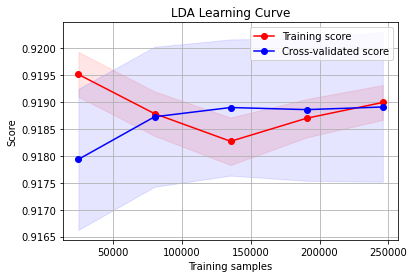

In [131]:
from sklearn.model_selection import learning_curve

plt.figure()
plt.title("LDA Learning Curve")
plt.xlabel("Training samples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
        LDA_best, df_train, target, cv=kfolds, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

# Two areá
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
# Two curves
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validated score")

plt.legend(loc="best")

## Result

In [132]:
output_df = pd.DataFrame({"SK_ID_CURR": test_index,
                          "TARGET": lda_pred})
output_df.to_csv("atien228_lda_grid_submission.csv", index=False)

## [Problem 5]


After submitting to Kaggle, I have been evaluated, and get a ROC AUC score of 0.53093. This Decision Tree Classifier worked a little better than Linear Regression in term of predicting probatility, whereas it run time consumer way longer than we expected.
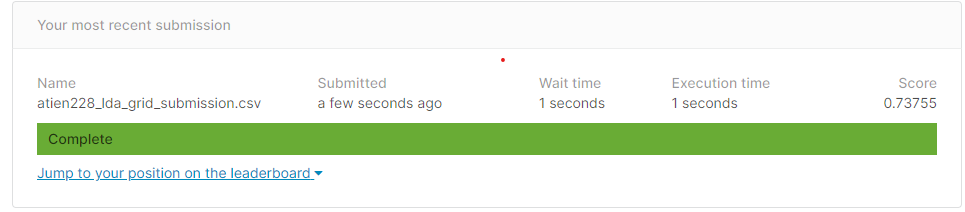

In [137]:
scores = {'1. Logistic Regression': [0.50389], 
          '2. Default Random Forest': [0.68297], 
          '3. Tuned Random Forest': [0.70399], 
          '4. Linear Discriminate Analysis': [0.72394],
          '5. Decision Tree': [0.53093],
          '6. Tuned Random Forest (GridSearchCV and KFolds)': [0.73755]}
metric = ['ROC AUC Score']
df_results = pd.DataFrame(data=scores, index = metric).T
df_results

,ROC AUC Score
1. Logistic Regression,0.50389
2. Default Random Forest,0.68297
3. Tuned Random Forest,0.70399
4. Linear Discriminate Analysis,0.72394
5. Decision Tree,0.53093
6. Tuned Random Forest (GridSearchCV and KFolds),0.73755


After this assignment, what I have learned and adopted is to learn more about the mechanism of K-Folds Cross-Validation and GridSearchCV.

In fact, during the assignment, I have tried to use the Linear Discriminate Analysis since it is the best performed algorithm I have ever used, but then got error due to its input. Consequently, I found out that my dataset has not been standardized in order to fit with the LDA estimator, so I fixed it by using Pipeline in which the StandardScaler() will put along with the LDA estimator; and the model works perfectly.

The accuracy this time is better than those of five algorithms implemented from the last assignment. This is actually a good sign, and I think this model still have some spaces for improvements in the future.